In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [39]:
df_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', parse_dates=['Month'], index_col='Month')
df_rob = pd.read_csv('monthly-boston-armed-robberies-j.csv', parse_dates=['Month'], index_col='Month')

In [40]:
# 1. Стационарный ряд (ограбления в Бостоне после преобразований)
df_rob['log'] = np.log(df_rob['Count'])
df_rob['diff'] = df_rob['log'].diff(1)
df_rob.dropna(inplace=True)

# 2. Нестцаионарный ряд (температура воздуха)
df_temp.dropna(inplace=True)

In [41]:
# Разделение на обучающую и тестовую выборки
def train_test_split(data, test_size=0.2):
    split_idx = int(len(data) * (1 - test_size))
    return data[:split_idx], data[split_idx:]

In [42]:
# Для стационарного ряда
train_stat, test_stat = train_test_split(df_rob['diff'])

# Для нестационарного ряда
train_nonstat, test_nonstat = train_test_split(df_temp['Deg'])

In [43]:
# Функция для подбора модели MA
def fit_ma_model(data, q):
    model = ARIMA(data, order=(0, 0, q))  # (p=0, d=0, q=q) — модель MA(q)
    model_fit = model.fit()
    return model_fit

In [44]:
# Подбор модели MA для стационарного ряда
ma_stat = fit_ma_model(train_stat, q=1)  # q=1 — пример, можно подобрать оптимальное q
print("Результаты модели MA(1) для стационарного ряда:")
print(ma_stat.summary())

C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Результаты модели MA(1) для стационарного ряда:
                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                   93
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  15.755
Date:                Tue, 04 Mar 2025   AIC                            -25.510
Time:                        23:55:19   BIC                            -17.913
Sample:                    02-01-1966   HQIC                           -22.443
                         - 10-01-1973                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.011      2.098      0.036       0.001       0.044
ma.L1         -0.4953      0.089     -5.557      0.000      -0.670      -0.321
sigm

In [45]:
# Прогнозирование для стационарного ряда
forecast_stat = ma_stat.predict(start=len(train_stat), end=len(train_stat) + len(test_stat) - 1)

In [46]:
# Оценка для стационарного ряда
mse_stat = mean_squared_error(test_stat, forecast_stat)
print(f'MSE для стационарного ряда (MA(1)): {mse_stat}')

MSE для стационарного ряда (MA(1)): 0.02388433914226905


In [47]:
# Построение модели TEMA для нестационарного ряда
model_tema = ExponentialSmoothing(
    train_nonstat,
    trend='add',          # Учитываем тренд
    seasonal='add',       # Учитываем сезонность
    seasonal_periods=12   # Устанавливаем сезонность 12 месяцев
)
fit_tema = model_tema.fit()

C:\Users\Hamster\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
# Прогнозирование для нестационарного ряда
forecast_nonstat = fit_tema.forecast(steps=len(test_nonstat))

In [49]:
# Оценка для нестационарного ряда
mse_nonstat = mean_squared_error(test_nonstat, forecast_nonstat)
print(f'MSE для нестационарного ряда (TEMA): {mse_nonstat}')

MSE для нестационарного ряда (TEMA): 4.632070573936121


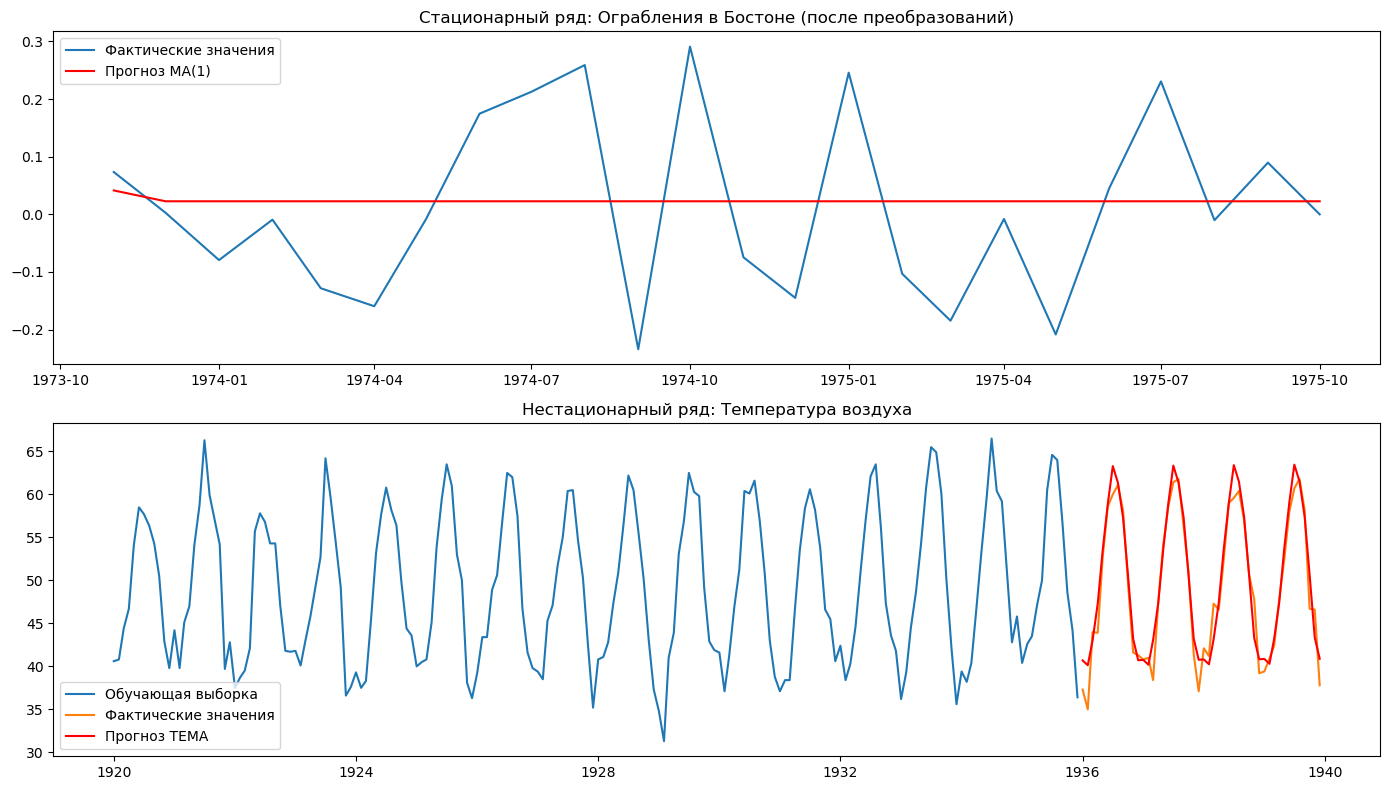

In [50]:
# Визуализация результатов
plt.figure(figsize=(14, 8))

# Стационарный ряд
plt.subplot(2, 1, 1)
plt.plot(test_stat.index, test_stat, label='Фактические значения')
plt.plot(test_stat.index, forecast_stat, label='Прогноз MA(1)', color='red')
plt.title('Стационарный ряд: Ограбления в Бостоне (после преобразований)')
plt.legend()

# Нестационарный ряд
plt.subplot(2, 1, 2)
plt.plot(train_nonstat.index, train_nonstat, label='Обучающая выборка')
plt.plot(test_nonstat.index, test_nonstat, label='Фактические значения')
plt.plot(test_nonstat.index, forecast_nonstat, label='Прогноз TEMA', color='red')
plt.title('Нестационарный ряд: Температура воздуха')
plt.legend()

plt.tight_layout()
plt.show()

## Графики:
- Для стационарного ряда: прогноз MA(1) близок к фактическим значениям.
- Для нестационарного ряда: прогноз TEMA учитывает тренд и сезонность.

## Выводы

MA(1):
- Подходит для стационарных рядов.

TEMA:
- Подходит для нестационарных рядов с трендом и сезонностью.
- Учитывает оба компонента, что улучшает качество прогноза.